In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, mannwhitneyu
from sklearn.linear_model import LinearRegression

from matplotlib.colors import LinearSegmentedColormap
import mpl_scatter_density # needed for density scatter plots
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize

# COLORS:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list("white_viridis", [
    (0, "#ffffff"),
    (1e-20, "#440053"),
    (0.2, "#404388"),
    (0.4, "#2a788e"),
    (0.6, "#21a784"),
    (0.8, "#78d151"),
    (1, "#fde624"),
], N=256)
# "Viridis-like" colormap with white background
white_viridis_r = LinearSegmentedColormap.from_list("white_viridis", [
    (0, "#ffffff"),
    (1e-20, "#fde624"),
    (0.4, "#78d151"),
    (0.6, "#21a784"),
    (0.7, "#2a788e"),
    (0.8, "#404388"),
    (1, "#440053"),
], N=256)
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

In [2]:
print(
    "scp cbsu:/fs/cbsubscb17/storage/projects/CLIPNET_transfer/k562_siraj_mpra/k562_allelic_mpra_snps.csv.gz ~/github/scratch"
)

scp cbsu:/fs/cbsubscb17/storage/projects/CLIPNET_transfer/k562_siraj_mpra/k562_allelic_mpra_snps.csv.gz ~/github/scratch


In [3]:
data = pd.read_csv("~/github/scratch/k562_allelic_mpra_snps_exp.csv.gz")
data = data[
    [
        "fold", "variant", "emVar_K562", "active_K562", "log2fc_expt",
        "log2fc_clipnet_ensemble", "log2fc_clipnet_holdout", "log2fc_clipnet_reference_ensemble", 
        "log2fc_procapnet_ensemble"
    ]
    + [f"log2fc_procapnet_fold_{i}" for i in range(7)]
]
data = data.dropna()

In [4]:
data = data[np.isfinite(data["log2fc_clipnet_holdout"])]
data.dropna(inplace=True)

null_data = data[(data.emVar_K562 == 0) & (data.active_K562 == 1)]
data = data[data.emVar_K562 == 1]

In [5]:
pearsons_clipnet_ensemble = pearsonr(data["log2fc_expt"], data["log2fc_clipnet_ensemble"])[0]
pearsons_clipnet_reference = pearsonr(data["log2fc_expt"], data["log2fc_clipnet_reference_ensemble"])[0]
pearsons_clipnet_reference_holdout = pearsonr(data[data["fold"] == 0]["log2fc_expt"], data[data["fold"] == 0]["log2fc_clipnet_reference_ensemble"])[0]
pearsons_clipnet_holdout = pearsonr(data[data["fold"] == 0]["log2fc_expt"], data[data["fold"] == 0]["log2fc_clipnet_holdout"])[0]
pearsons_clipnet_folds = [pearsonr(data[data["fold"] == i]["log2fc_expt"], data[data["fold"] == i]["log2fc_clipnet_holdout"])[0] for i in range(1, 10)]
pearsons_procapnet_ensemble = pearsonr(data["log2fc_expt"], data["log2fc_procapnet_ensemble"])[0]
pearsons_procapnet_folds = [pearsonr(data["log2fc_expt"], data[f"log2fc_procapnet_fold_{i}"])[0] for i in range(7)]
#print(pearsons[0], pearsons_procapnet)

pearsons_plot = pd.DataFrame(pearsons_clipnet_folds + pearsons_procapnet_folds, index=["CLIPNET -> K562"] * 9 + ["ProCapNet K562"] * 7)
pearsons_plot.reset_index(inplace=True)
pearsons_plot.columns = ["Model", "Pearson (expt vs pred emVar)"]

<Axes: xlabel='Model', ylabel='Pearson (expt vs pred emVar)'>

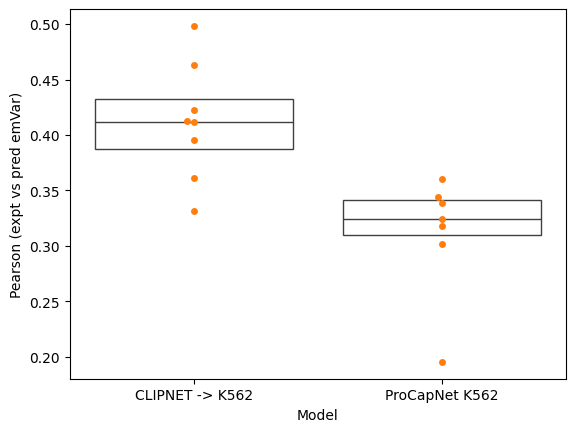

In [6]:
sns.boxplot(
    data=pearsons_plot[1:], x="Model", y="Pearson (expt vs pred emVar)",
    boxprops={'facecolor':'None'}, showfliers=False, whiskerprops={'linewidth':0}, showcaps=False,
)
sns.swarmplot(data=pearsons_plot[1:], x="Model", y="Pearson (expt vs pred emVar)")

In [7]:
signs = [
    (np.sign(data[data.fold == fold].log2fc_clipnet_holdout) == np.sign(data[data.fold == fold].log2fc_expt)).mean()
    for fold in range(10)
]
signs_procapnet = (np.sign(data.log2fc_procapnet_ensemble) == np.sign(data.log2fc_expt)).mean()
signs_procapnet_folds = [
    (np.sign(data[f"log2fc_procapnet_fold_{i}"]) == np.sign(data.log2fc_expt)).mean()
    for i in range(7)
]

signs_plot = pd.DataFrame(
    signs[1:] + signs_procapnet_folds,
    index=["CLIPNET -> K562"] * 9 + ["ProCapNet K562"] * 7
)
signs_plot.reset_index(inplace=True)
signs_plot.columns = ["Model", "\\% predictions with correct sign"]

<>:5: SyntaxWarning: invalid escape sequence '\%'
<>:5: SyntaxWarning: invalid escape sequence '\%'
/var/folders/sd/3462tpx12fbfxc_f8swcwyf40000gp/T/ipykernel_2950/4210916466.py:5: SyntaxWarning: invalid escape sequence '\%'
  sns.swarmplot(data=signs_plot[1:], x="Model", y="\% predictions with correct sign")


<Axes: xlabel='Model', ylabel='\\% predictions with correct sign'>

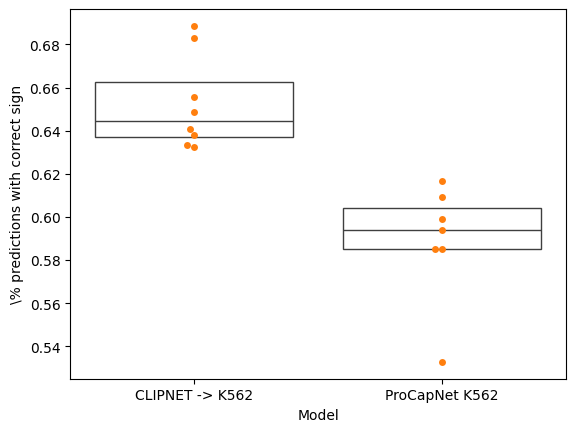

In [8]:
sns.boxplot(
    data=signs_plot[1:], x="Model", y="\\% predictions with correct sign",
    boxprops={'facecolor':'None'}, showfliers=False, whiskerprops={'linewidth':0}, showcaps=False,
)
sns.swarmplot(data=signs_plot[1:], x="Model", y="\% predictions with correct sign")

/Users/adamhe/miniforge3/envs/plt/lib/python3.12/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/adamhe/miniforge3/envs/plt/lib/python3.12/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


PearsonRResult(statistic=0.35141314879049484, pvalue=1.6672629204478197e-66)

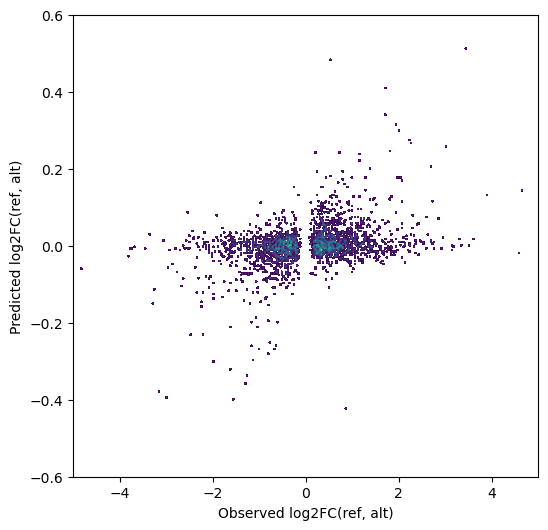

In [12]:
# Plot predicted vs observed log quantities

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
density = ax.scatter_density(
    data["log2fc_expt"][data["fold"] == 0],
    data["log2fc_procapnet_ensemble"][data["fold"] == 0],
    cmap=white_viridis
)
#fig.colorbar(density)
ax.set_xlim(-5, 5)
ax.set_ylim(-0.6, 0.6)
#ax.set_yticks([-0, 3])
#ax.set_yticklabels(["", ""])
#ax.set_xticks([-0, 3])
#ax.set_xticklabels(["", ""])
ax.set_ylabel("Predicted log2FC(ref, alt)")
ax.set_xlabel("Observed log2FC(ref, alt)")
plt.savefig("img/procapnet_ensemble_mpra_predictions.pdf")

pearsonr(data["log2fc_expt"][data["fold"] == 0], data["log2fc_procapnet_ensemble"][data["fold"] == 0])

In [ ]:
pearsonr(data["log2fc_expt"][data["fold"] == 0], data["log2fc_procapnet_ensemble"][data["fold"] == 0])

In [17]:
(np.sign(data["log2fc_expt"][data["fold"] == 0]) == np.sign(data["log2fc_procapnet_ensemble"][data["fold"] == 0])).mean()

0.5949423247559894

/Users/adamhe/miniforge3/envs/plt/lib/python3.13/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/adamhe/miniforge3/envs/plt/lib/python3.13/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


PearsonRResult(statistic=0.5119878717541413, pvalue=7.245602324403845e-151)

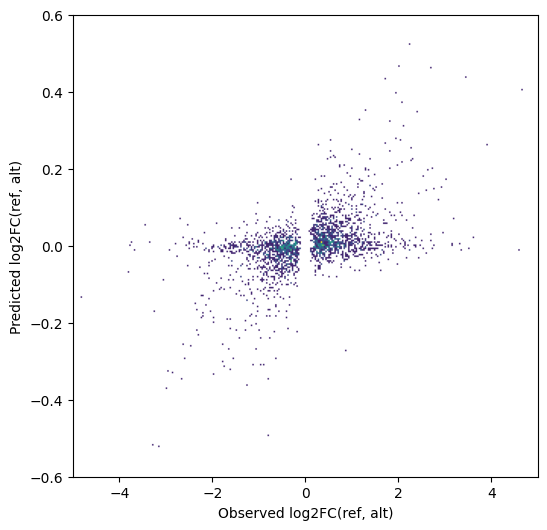

In [10]:
# Plot predicted vs observed log quantities

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
density = ax.scatter_density(
    data["log2fc_expt"][data["fold"] == 0],
    data["log2fc_clipnet_ensemble"][data["fold"] == 0],
    cmap=white_viridis
)
#fig.colorbar(density)
ax.set_xlim(-5, 5)
ax.set_ylim(-0.6, 0.6)
#ax.set_yticks([-0, 3])
#ax.set_yticklabels(["", ""])
#ax.set_xticks([-0, 3])
#ax.set_xticklabels(["", ""])
ax.set_ylabel("Predicted log2FC(ref, alt)")
ax.set_xlabel("Observed log2FC(ref, alt)")
plt.savefig("img/clipnet_ensemble_mpra_predictions.pdf")

pearsonr(data["log2fc_expt"][data["fold"] == 0], data["log2fc_clipnet_ensemble"][data["fold"] == 0])
#(np.sign(data["log2fc_expt"][data["fold"] == 0]) == np.sign(data["log2fc_clipnet_ensemble"][data["fold"] == 0])).mean()

/Users/adamhe/miniforge3/envs/plt/lib/python3.13/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/adamhe/miniforge3/envs/plt/lib/python3.13/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


PearsonRResult(statistic=0.4816752334147656, pvalue=2.8309228769530187e-131)

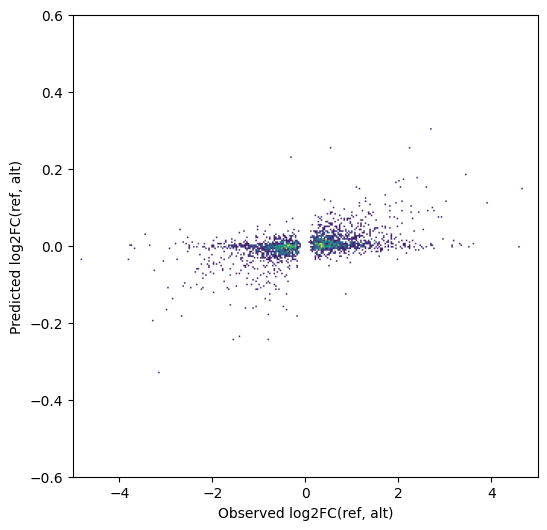

In [11]:
# Plot predicted vs observed log quantities

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
density = ax.scatter_density(
    data["log2fc_expt"][data["fold"] == 0],
    data["log2fc_clipnet_reference_ensemble"][data["fold"] == 0],
    cmap=white_viridis
)
#fig.colorbar(density)
ax.set_xlim(-5, 5)
ax.set_ylim(-0.6, 0.6)
#ax.set_yticks([-0, 3])
#ax.set_yticklabels(["", ""])
#ax.set_xticks([-0, 3])
#ax.set_xticklabels(["", ""])
ax.set_ylabel("Predicted log2FC(ref, alt)")
ax.set_xlabel("Observed log2FC(ref, alt)")
plt.savefig("img/clipnet_reference_ensemble_mpra_predictions.pdf")

pearsonr(data["log2fc_expt"][data["fold"] == 0], data["log2fc_clipnet_reference_ensemble"][data["fold"] == 0])
#(np.sign(data["log2fc_expt"][data["fold"] == 0]) == np.sign(data["log2fc_clipnet_reference_ensemble"][data["fold"] == 0])).mean()